# Data Preprocessing

## Import libraries

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

## Upload all the datasets

In [11]:
airline = pd.read_csv('airlines_slogan.csv', encoding='utf-8')
apparel = pd.read_csv('apparel_slogan.csv', encoding='utf-8')
beauty = pd.read_csv('cosmetics_slogan.csv', encoding='utf-8')
business = pd.read_csv('business_slogan.csv', encoding='utf-8')
campaign = pd.read_csv('campaign_slogan.csv', encoding='utf-8')
car = pd.read_csv('car_slogan.csv', encoding='utf-8')
company = pd.read_csv('company_slogan.csv', encoding='utf-8')
drinking = pd.read_csv('drinking_slogan.csv', encoding='utf-8')
education = pd.read_csv('education_slogan.csv', encoding='utf-8')
financial = pd.read_csv('financial_slogan.csv', encoding='utf-8')
food = pd.read_csv('food_slogan.csv', encoding='utf-8')
health = pd.read_csv('health_slogan.csv', encoding='utf-8')
household = pd.read_csv('household_slogan.csv', encoding='utf-8')
restaurant = pd.read_csv('restaurant_slogan.csv', encoding='utf-8')
sports = pd.read_csv('sports_slogan.csv', encoding='utf-8')
technology = pd.read_csv('technology_slogan.csv', encoding='utf-8')
television = pd.read_csv('television_slogan.csv', encoding='utf-8')
tours = pd.read_csv('tours_slogan.csv', encoding='utf-8')
uncategorized = pd.read_csv('uncategorized_slogan.csv', encoding='utf-8')

In [12]:
# df = pd.read_csv('all_slogans.csv', sep=';') # Load the dataset after the merge

## Merge the datasets

In [13]:
df = pd.DataFrame()
df = pd.concat([airline, apparel, beauty, business, campaign, car, company, drinking, education, financial, food, health, household, restaurant, sports, technology, television, tours, uncategorized], ignore_index=True)
df = df[['Company', 'Category', 'Slogans']]
len(df)

14171

In [14]:
df.head()

,Company,Category,Slogans
0,EgyptAir,Airlines,Makes all the difference. (1978)
1,EgyptAir,Airlines,The international airline of Egypt. (1983)
2,EgyptAir,Airlines,The way I like to travel. (2016)
3,Canadian Air,Airlines,We ship your world. (1988)
4,Canadian Air,Airlines,The easy choice. (1989)


## Rename the columns

In [15]:
df = df.rename(columns={'Slogans': 'slogan', 'Category': 'category', 'Company': 'company'})
df

,company,category,slogan
0,EgyptAir,Airlines,Makes all the difference. (1978)
1,EgyptAir,Airlines,The international airline of Egypt. (1983)
2,EgyptAir,Airlines,The way I like to travel. (2016)
3,Canadian Air,Airlines,We ship your world. (1988)
4,Canadian Air,Airlines,The easy choice. (1989)
...,...,...,...
14166,Andhra Pradesh,Uncategorized,The Kohinoor Of India
14167,Andhra Pradesh,Uncategorized,The Essence of Incredible India
14168,Bangalore,Uncategorized,Space City
14169,Bangalore,Uncategorized,Garden City of India


## Exploration

In [16]:
df['category'].value_counts()

Drinking         2466
Company          2327
Food             1381
Tours            1180
Business          913
Car               874
Apparel           823
Technology        714
Airlines          603
Restaurant        590
Cosmetics         537
Financial         531
Uncategorized     451
Television        237
Household         212
Sports            159
Education          66
food               58
Campaign           27
Health             22
Name: category, dtype: int64

Text(0, 0.5, 'Category')

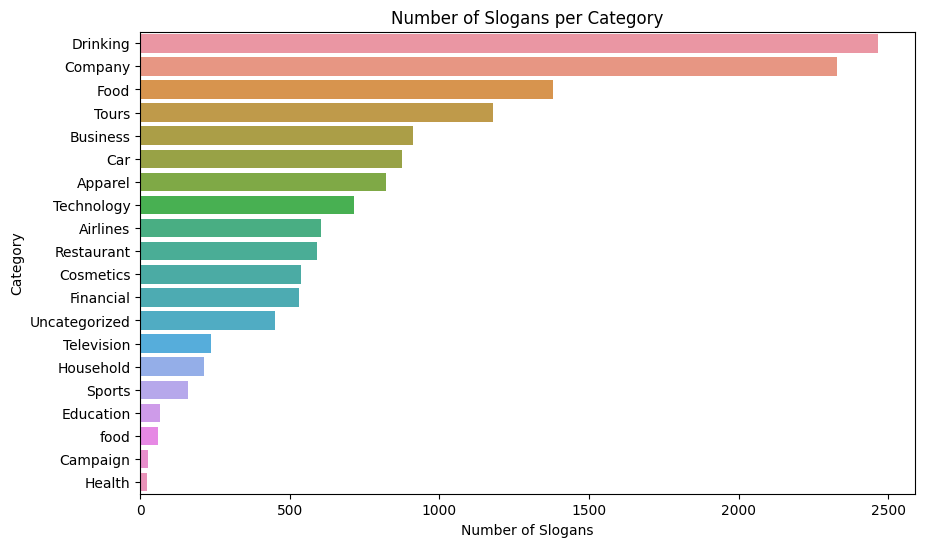

In [17]:
plt.figure(figsize=(10, 6))
sns.countplot(y='category', data=df, order=df['category'].value_counts().index)
plt.title('Number of Slogans per Category')
plt.xlabel('Number of Slogans')
plt.ylabel('Category')

The slogans are divided into 20 categories. The distribution of slogans in each category is not balanced. The category with the most slogans is "Drinking" while the category with the least slogans is "Health".

## Pretraining operations

Before diving into the training, we need to do some preprocessing on the data.

- Mask the name of the company if present. This is to prevent the model from learning the name of the company and to generate slogans that contain the name of the company in a logical way.
- Remove the notations in brackets from the slogans. Some slogans cotain notations in brackets that are not part of the slogan, such as the year of the slogan or its translation in another language.
- Create the prompt and output column, to be passed to the model.

### Remove the parenthesis from the rows

Usually the parenthesis are at the end of the slogan, so we can use RegEx to remove them.

The regex pattern, `\.* *\( *.*\)*`, can be broken down as follows:

1. `\.*`: This part matches zero or more occurrences of a dot character (`.`). The dot character is escaped with a backslash (`\`) because it is a special character in regex that matches any character except a newline. The asterisk (`*`) indicates that the dot can appear zero or more times.

2. ` *`: This part matches zero or more spaces. The space character doesn't need to be escaped and the asterisk (`*`) specifies that it can appear zero or more times.

3. `\( *.*\)*`: This part is enclosed in parentheses and matches zero or more occurrences of the following pattern:
   - `\( \)`: The parentheses themselves need to be escaped with a backslash to be treated as literal characters and not as grouping or capturing syntax.
   - `*.*`: This matches zero or more spaces followed by any character(s) except a newline. The dot (`.`) matches any character and the asterisk (`*`) specifies that it can appear zero or more times.

In [18]:
def remove_parentheses(row):
    row['company'] = re.sub(r'\.* *\( *.*\)*', '', row['company'])
    row['slogan'] = re.sub(r'\.* *\( *.*\)*', '', row['slogan'])
    return row

df = df.apply(remove_parentheses, axis=1)
df.head()

,company,category,slogan
0,EgyptAir,Airlines,Makes all the difference
1,EgyptAir,Airlines,The international airline of Egypt
2,EgyptAir,Airlines,The way I like to travel
3,Canadian Air,Airlines,We ship your world
4,Canadian Air,Airlines,The easy choice


### Remove slogans that are in another language

Firstly, we drop `NaN` values, to be sure that we don't have any `NaN` values in the dataset.
The database presents slogans in different languages. We want to keep only the slogans in English.\
To do so, we use the `langdetect` library to detect the language of the slogan. If the language is not English, we remove the slogan.

In case the library is not able to detect the language, we lable the language as `unknown`.

In [19]:
df = df.dropna()

from langdetect import detect
def detect_language(row):
    try:
        row['language'] = detect(row['slogan'])
    except:
        row['language'] = 'unknown'
    return row

df = df.apply(detect_language, axis=1)

df.head()

,company,category,slogan,language
0,EgyptAir,Airlines,Makes all the difference,en
1,EgyptAir,Airlines,The international airline of Egypt,en
2,EgyptAir,Airlines,The way I like to travel,en
3,Canadian Air,Airlines,We ship your world,en
4,Canadian Air,Airlines,The easy choice,en


In [20]:
df.language.value_counts()

en         11646
fr           422
de           239
no           205
af           193
nl           178
da           141
it           132
tl           126
ro           119
es            96
ca            81
so            80
id            79
et            61
cy            55
pt            51
sv            43
sw            39
fi            36
pl            26
tr            24
sl            17
sq            16
sk            14
hr            10
cs             8
ja             8
lt             6
vi             5
ko             4
unknown        3
hu             3
zh-cn          2
el             1
lv             1
ru             1
Name: language, dtype: int64

As we can see, most of the slogans are in English, but there are also slogans in other languages, such as French, Spanish, German, Italian, and so on.

In [21]:
df = df[df['language'] == 'en'].reset_index(drop=True)
len(df)

11646

Now the dataset has 11646 valid slogans that we can use to develop our model.

### Mask the name of the company

We want to mask the name of the company in the slogan, if present.\
This is to prevent the model from learning the name of the company and to generate slogans that contain the name of the company in a logical way.

We create the function `replace_org_name`, which checks if the name of the company is present in the slogan. If it is, it replaces the name of the company with the string `<company>`. This string will be used as a special token for the GPT model.

In [22]:
def replace_org_name(row):
    if row['company'] in row['slogan']:
        row['slogan_masked'] = row['slogan'].replace(row['company'], '<company>')
    else:
        row['slogan_masked'] = row['slogan']
    return row

df = df.apply(replace_org_name, axis=1)
df.head(20)

,company,category,slogan,language,slogan_masked
0,EgyptAir,Airlines,Makes all the difference,en,Makes all the difference
1,EgyptAir,Airlines,The international airline of Egypt,en,The international airline of Egypt
2,EgyptAir,Airlines,The way I like to travel,en,The way I like to travel
3,Canadian Air,Airlines,We ship your world,en,We ship your world
4,Canadian Air,Airlines,The easy choice,en,The easy choice
5,Canadian Air,Airlines,Focused: On you,en,Focused: On you
6,Aurigny,Airlines,The channel airline,en,The channel airline
7,Aurigny,Airlines,Rediscover what life’s about,en,Rediscover what life’s about
8,Aurigny,Airlines,The Channel Islands airline,en,The Channel Islands airline
9,Aurigny,Airlines,The islands’ preferred airline,en,The islands’ preferred airline


### Create the *prompt* column

Once the data are correctly preprocessed, we can create the *prompt* column.\
The *prompt* column is the column that will be passed to the model as input, to generate the slogan.

To create the column we concatenate the name of the company with the category, separated by a comma.

In [23]:
def prompt(row):
    return ''.join([row['company'], ', ', row['category']])

df['prompt'] = df.apply(prompt, axis=1)
df.head(20)

,company,category,slogan,language,slogan_masked,prompt
0,EgyptAir,Airlines,Makes all the difference,en,Makes all the difference,"EgyptAir, Airlines"
1,EgyptAir,Airlines,The international airline of Egypt,en,The international airline of Egypt,"EgyptAir, Airlines"
2,EgyptAir,Airlines,The way I like to travel,en,The way I like to travel,"EgyptAir, Airlines"
3,Canadian Air,Airlines,We ship your world,en,We ship your world,"Canadian Air, Airlines"
4,Canadian Air,Airlines,The easy choice,en,The easy choice,"Canadian Air, Airlines"
5,Canadian Air,Airlines,Focused: On you,en,Focused: On you,"Canadian Air, Airlines"
6,Aurigny,Airlines,The channel airline,en,The channel airline,"Aurigny, Airlines"
7,Aurigny,Airlines,Rediscover what life’s about,en,Rediscover what life’s about,"Aurigny, Airlines"
8,Aurigny,Airlines,The Channel Islands airline,en,The Channel Islands airline,"Aurigny, Airlines"
9,Aurigny,Airlines,The islands’ preferred airline,en,The islands’ preferred airline,"Aurigny, Airlines"


### Create the *output* column

To train the model, we need to pass the slogan as output.\
To do so, we create the *output* column, which contains the company name and the slogan, separated by a comma.


In [24]:
def output(row):
    return ''.join([row['company'], ', ', row['slogan']])

df['output'] = df.apply(output, axis=1)
df.head()

,company,category,slogan,language,slogan_masked,prompt,output
0,EgyptAir,Airlines,Makes all the difference,en,Makes all the difference,"EgyptAir, Airlines","EgyptAir, Makes all the difference"
1,EgyptAir,Airlines,The international airline of Egypt,en,The international airline of Egypt,"EgyptAir, Airlines","EgyptAir, The international airline of Egypt"
2,EgyptAir,Airlines,The way I like to travel,en,The way I like to travel,"EgyptAir, Airlines","EgyptAir, The way I like to travel"
3,Canadian Air,Airlines,We ship your world,en,We ship your world,"Canadian Air, Airlines","Canadian Air, We ship your world"
4,Canadian Air,Airlines,The easy choice,en,The easy choice,"Canadian Air, Airlines","Canadian Air, The easy choice"


## Save the dataset

In [25]:
df.to_csv('all_slogans.csv', sep=';', index=False)